In [2]:
# import libraries

import numpy as np
from numpy import diff
import matplotlib.pyplot as plt
import random
from random import randrange
import scipy
from scipy import signal as sp
from scipy.io import wavfile
import librosa
import IPython.display as ipd
from perlin import *

In [3]:
# define plotting parameters

fig_width = 20
fig_height = 5

In [4]:
# define global variables

fs = 48000

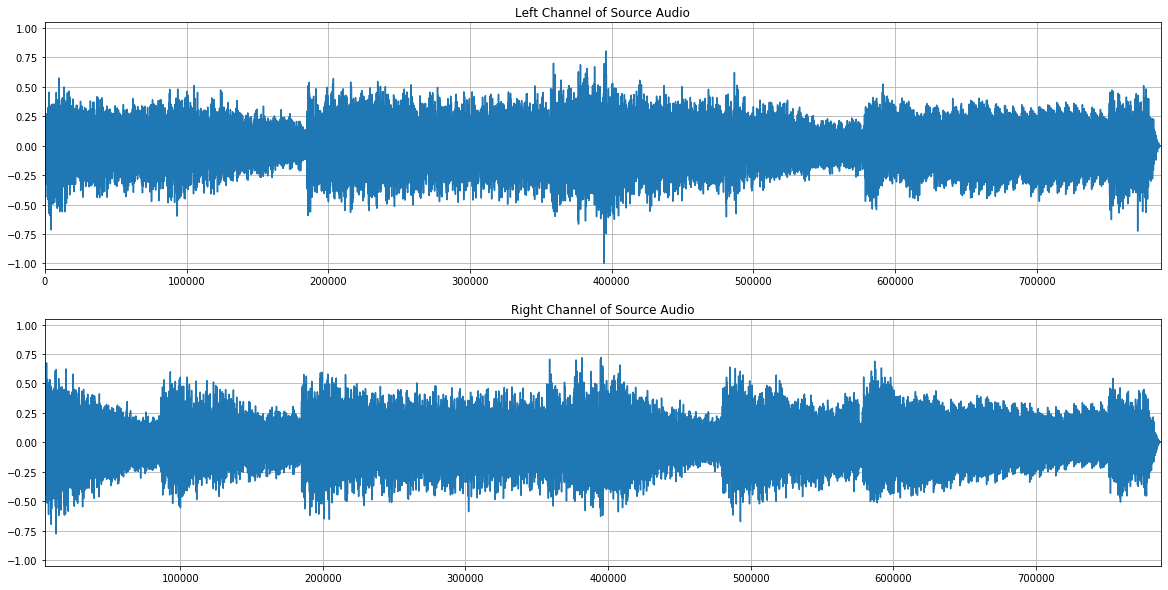

In [21]:
# import source audio (audio you want to process)

'''short audio files (< 10s) might not work well. has to be stereo. monofiles could be converted to
   pseudo-stereo files by doubling the mono channel. array shape has to be 
   [[left, channel, values, ...], [right, channel, values, ...]]'''

data, fs = librosa.load('source_audio/source_audio2.wav', sr=fs, mono=False)

signal = np.copy(data)
signal = np.array(signal, dtype=np.float64)
signal /= np.amax(np.abs(signal))

plt.figure(figsize=(fig_width, 2 * fig_height))
plt.subplot(2, 1, 1)
plt.title('Left Channel of Source Audio')
plt.plot(signal[0])
plt.grid('both')
plt.xlim([0, len(signal[0])])
plt.ylim([-1.05, 1.05])

plt.subplot(2, 1, 2)
plt.title('Right Channel of Source Audio')
plt.plot(signal[1])
plt.grid('both')
plt.xlim([5000, len(signal[1])])
plt.ylim([-1.05, 1.05])
plt.show()

ipd.Audio(signal[0], rate=fs)

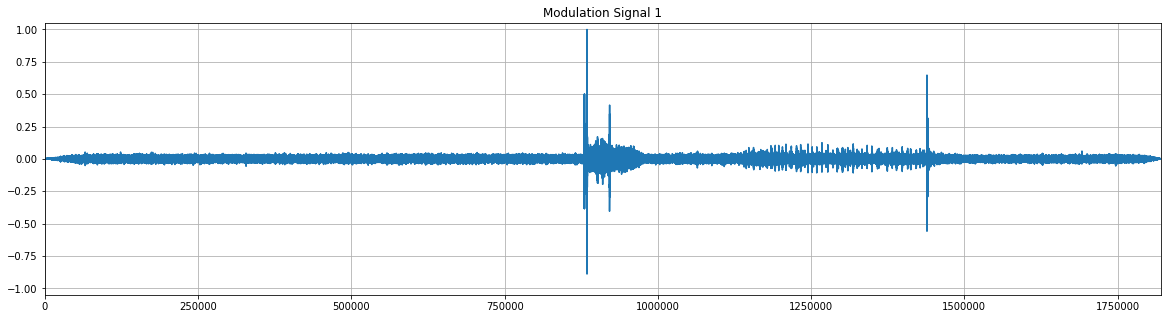

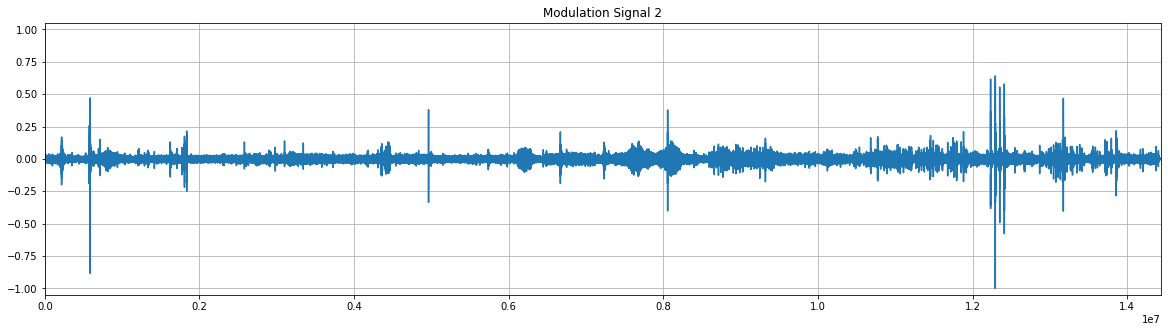

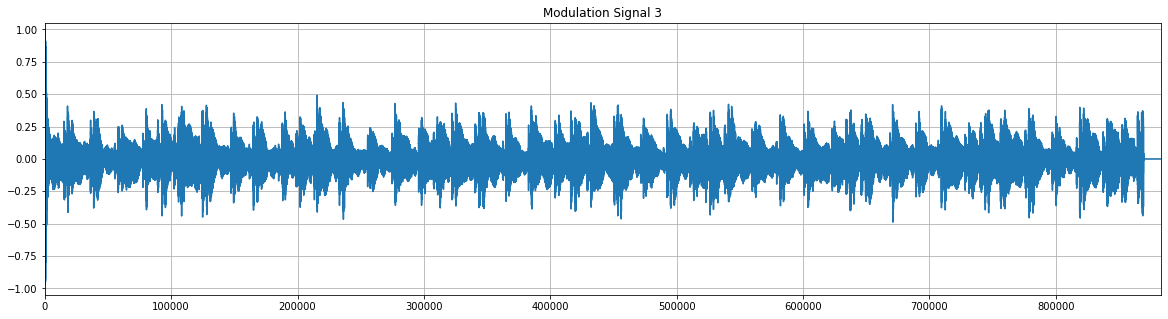

In [35]:
# import modulation audio for decay_mod_signal algorithm

mod_data1, fs = librosa.load('modulation_signals/mod_signal1.wav', sr=fs, mono=True)

mod_signal1 = np.copy(mod_data1)
mod_signal1 = np.array(mod_signal1, dtype=np.float64)
mod_signal1 /= np.amax(np.abs(mod_signal1))

mod_data2, fs = librosa.load('modulation_signals/mod_signal2.wav', sr=fs, mono=True)

mod_signal2 = np.copy(mod_data2)
mod_signal2 = np.array(mod_signal2, dtype=np.float64)
mod_signal2 /= np.amax(np.abs(mod_signal2))

mod_signals = [mod_signal1, mod_signal2]

for i in range(len(mod_signals)):

    plt.figure(figsize=(fig_width, fig_height))
    plt.title('Modulation Signal ' + str(i + 1))
    plt.plot(mod_signals[i])
    plt.grid('both')
    plt.xlim([0, len(mod_signals[i])])
    plt.ylim([-1.05, 1.05])
    plt.show()

In [50]:
# define functions

def log_scaling(x, a=100):
    
    return (a ** x - 1) / (a - 1)


def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))


def sigmoid_fade(signal, length, side='l'):
    
    sig_x_values = np.linspace(-6, 6, length)
    sig_values = sigmoid(sig_x_values)
    
    fade = sig_values
    fade = np.pad(fade, (0, len(signal) - length), 'constant', constant_values=(0, 1))
    
    if (side == 'r'):
        fade = np.flip(fade)
    
    signal *= fade
    
    return signal


def linear_fade(signal, length, side='l'):
    
    fade = np.linspace(0, 1, length)
    fade = np.pad(fade, (0, len(signal) - length), 'constant', constant_values=(0, 1))
    
    if (side == 'r'):
        fade = np.flip(fade)
    
    signal *= fade
    
    return signal


def perlin_noise(length, frequency):
    
    pn = Perlin(frequency)
    pn_x_values = [i for i in range(length)]
    pn_values = [pn.valueAt(i) for i in pn_x_values]
    
    return np.array(pn_values)


def decay_perlin(signal, index, width, weight, pn_frequency, pn_type, fade_l, fade_r):
    
    length = len(signal)
    ones = np.ones(length)
    decay_length = width
    
    # error messages
    if (decay_length > length):
        print('[decay_perlin()] Width must be lower than signal length! Returning unprocessed signal ...')
        return signal
    elif (fade_l > width or fade_r > width):
        print('[decay_perlin()] Fades must be lower than decay width! Returning unprocessed signal ...')
        return signal
    
    # perlin noise for amplitude modulation of higher frequency perlin noise
    pn_mod = perlin_noise(width, 2)
    pn_mod += 1
    pn_mod /= np.amax(np.abs(pn_mod))
    pn_mod = sigmoid_fade(pn_mod, fade_l, 'l')
    pn_mod = sigmoid_fade(pn_mod, fade_r, 'r')
    
    # higher frequency perlin noise
    pn = perlin_noise(width, pn_frequency)
    
    if (pn_type == 'smooth'):
        pn += 1
        pn /= np.amax(np.abs(pn))
    elif (pn_type == 'sharp'):
        pn = np.abs(pn)
        
    pn *= pn_mod
    pn *= weight
    
    # pad to length of signal and roll to index
    pn = np.pad(pn, (0, length - width), 'constant', constant_values=(0, 0))
    pn = np.roll(pn, -int(width/2))
    pn = np.roll(pn, index)
    
    # print perlin noise to signal
    pn = ones - pn
    signal *= pn
    
    return signal


def decay_mod_signal(signal, index, width, weight, mod_signal, fade_l, fade_r):
    
    length = len(signal)
    ones = np.ones(length)
    decay_length = width
    
    # error messages
    if (decay_length > length):
        print('[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...')
        return signal
    elif (fade_l > width or fade_r > width):
        print('[decay_mod_signal()] Fades must be lower than decay width! Returning unprocessed signal ...')
        return signal
    
    # perlin noise for amplitude modulation of modulation signal
    pn_mod = perlin_noise(width, 2)
    pn_mod += 1
    pn_mod /= np.amax(np.abs(pn_mod))
    pn_mod = sigmoid_fade(pn_mod, fade_l, 'l')
    pn_mod = sigmoid_fade(pn_mod, fade_r, 'r')
    
    # modulation signal
    ms_index = random.randint(0, len(mod_signal) - width)
    ms = np.copy(mod_signal[ms_index:ms_index + width])
    ms += 1
    ms /= np.amax(np.abs(ms))
    ms *= pn_mod
    ms *= weight
    
    # pad to length of signal and roll to index
    ms = np.pad(ms, (0, length - width), 'constant', constant_values=(0, 0))
    ms = np.roll(ms, -int(width/2))
    ms = np.roll(ms, index)
    
    # print modulation signal to signal
    ms = ones - ms
    signal *= ms
    
    return signal


def glitch(signal, index, width, weight, n):
    
    if (index + n * width > len(signal) - 1):
        index = len(signal) - 1
    
    # read glitch signal from index of signal
    glitch_signal = np.copy(signal[index:index + width])
    glitch_signal *= weight
    
    # fade glitch signal
    glitch_signal = sigmoid_fade(glitch_signal, int(len(glitch_signal) / 5), 'l')
    glitch_signal = sigmoid_fade(glitch_signal, int(len(glitch_signal) / 5), 'r')
    
    # combine glitch signals
    glitch_signal_sum = []
    for i in range(n_glitches):
        glitch_signal_sum.append(glitch_signal)
    glitch_signal_sum = [item for sublist in glitch_signal_sum for item in sublist]
    glitch_signal_sum = sigmoid_fade(glitch_signal_sum, int(len(glitch_signal_sum) / 10), 'l')
    glitch_signal_sum = sigmoid_fade(glitch_signal_sum, int(len(glitch_signal_sum) / 10), 'r')
    
    # very weird fix for a problem which returns broken glitch_signal_sums
    if (glitch_signal_sum[0] == glitch_signal_sum[1]):
        print('[glitch()] Corrupted glitch signal! Returning unprocessed signal ...')
        return signal
    
    # pad to length of signal and roll to index
    glitch_signal_sum = np.pad(glitch_signal_sum, (0, len(signal) - len(glitch_signal_sum)), 'constant', constant_values=(0, 0))
    glitch_signal_sum = np.roll(glitch_signal_sum, index + glitch_width)
    
    # print glitch to signal
    signal += glitch_signal_sum
    
    return signal

Epoch 1
   Index 1 (702661)


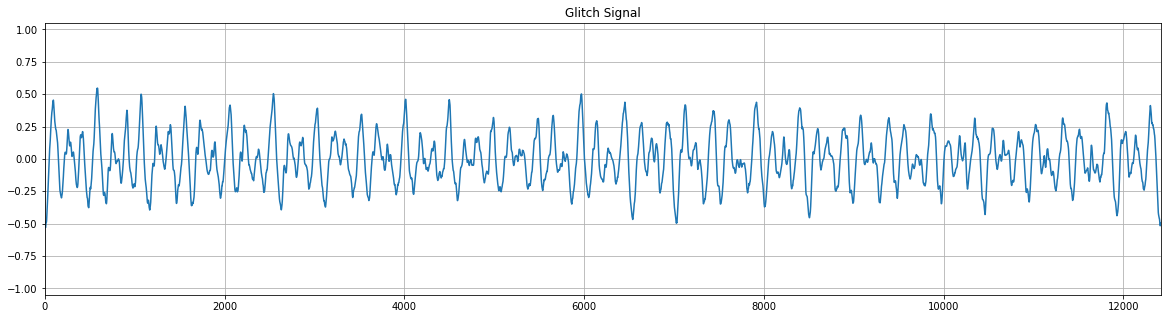

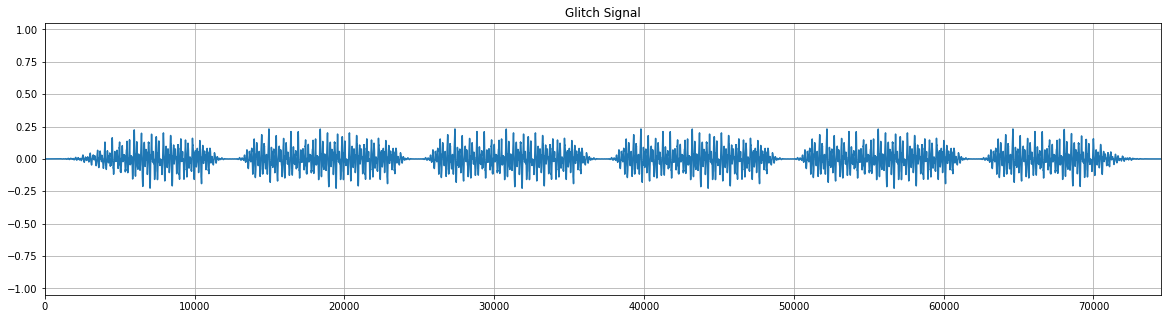

   Index 2 (415471)
   Index 3 (687430)


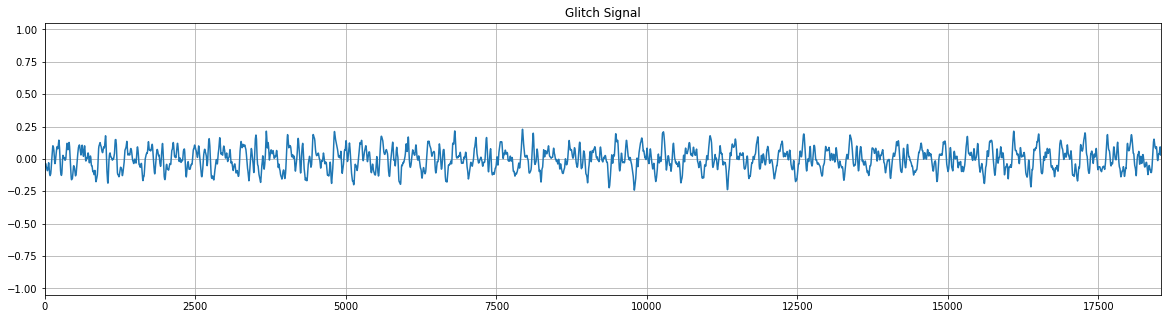

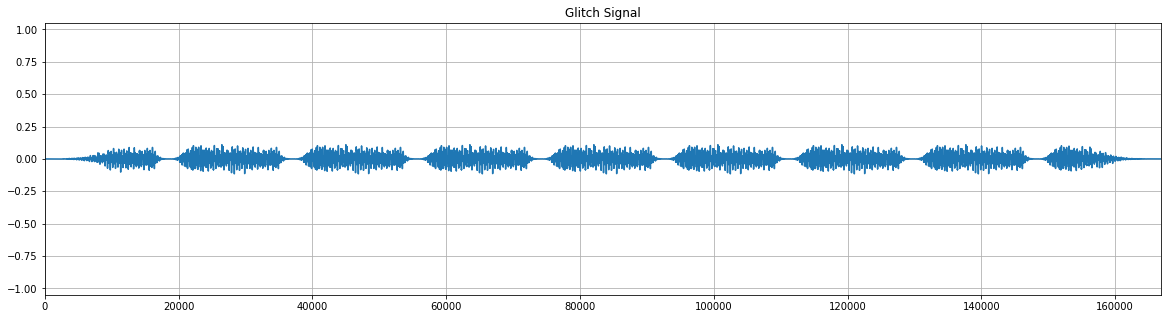

   Index 4 (585810)
   Index 5 (514937)
   Index 6 (440173)


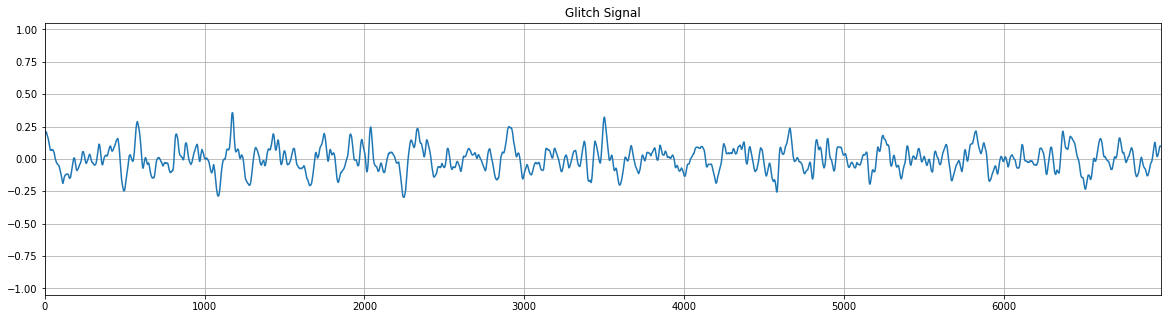

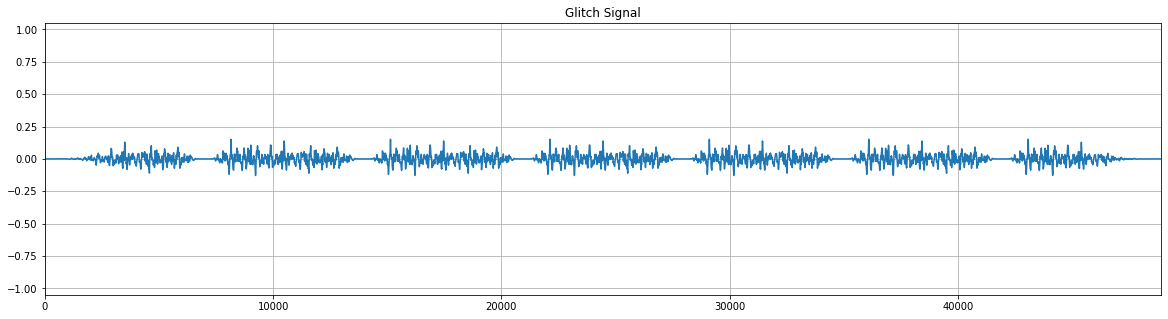

   Index 1 (380838)
   Index 2 (441252)
   Index 3 (540017)


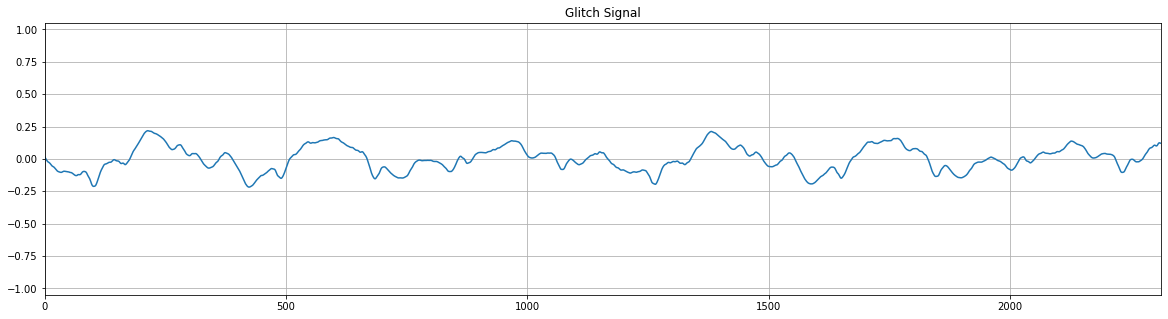

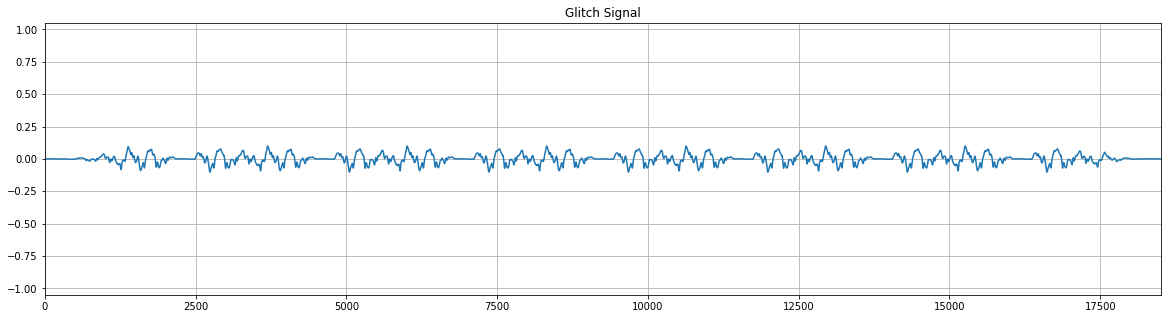

   Index 4 (137716)


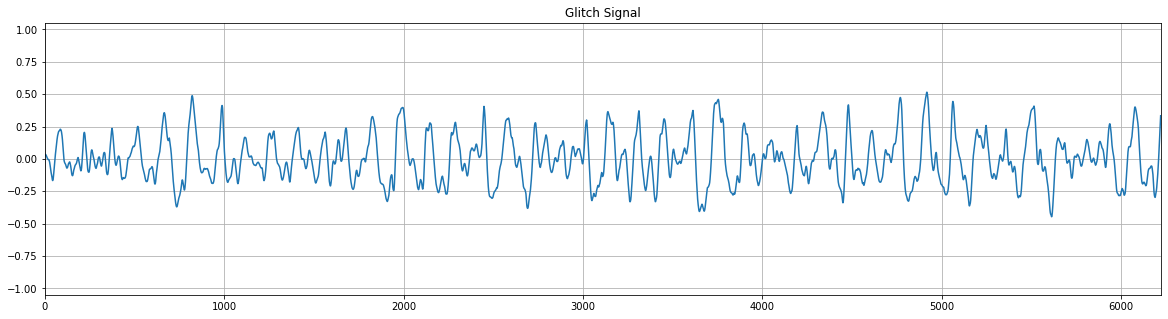

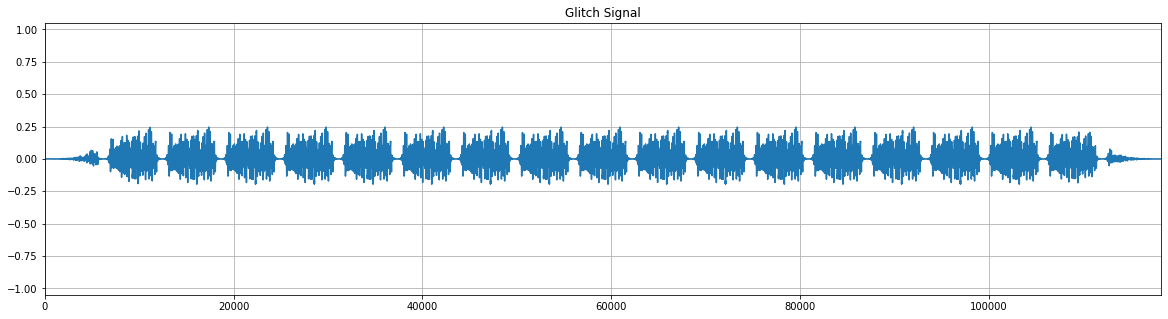

   Index 5 (394796)
   Index 6 (407535)
   Save audio . . .
Epoch 2


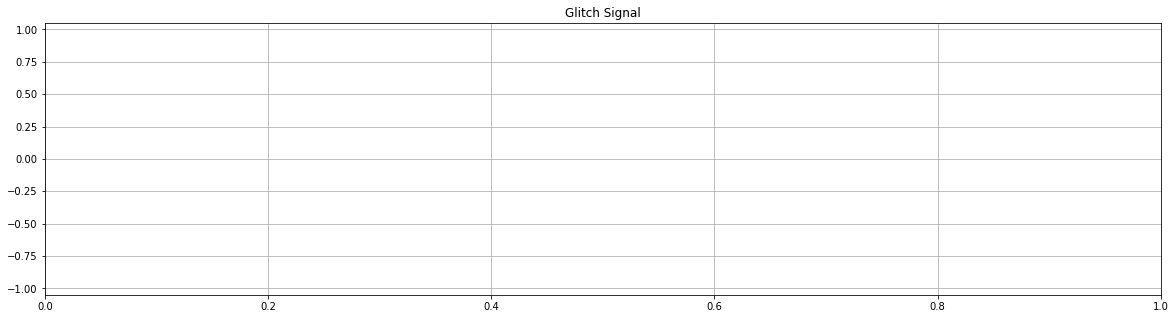

[glitch()] Corrupted glitch signal! Returning unprocessed signal ...
   Index 1 (603999)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 2 (140432)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 3 (380701)
   Index 4 (443665)


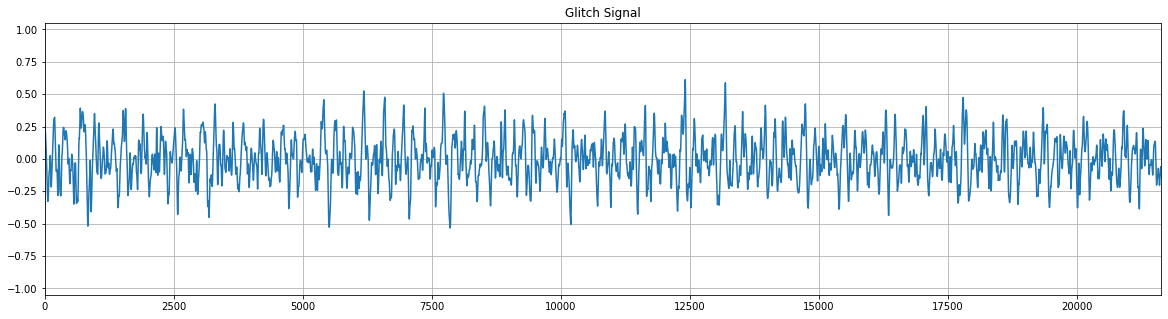

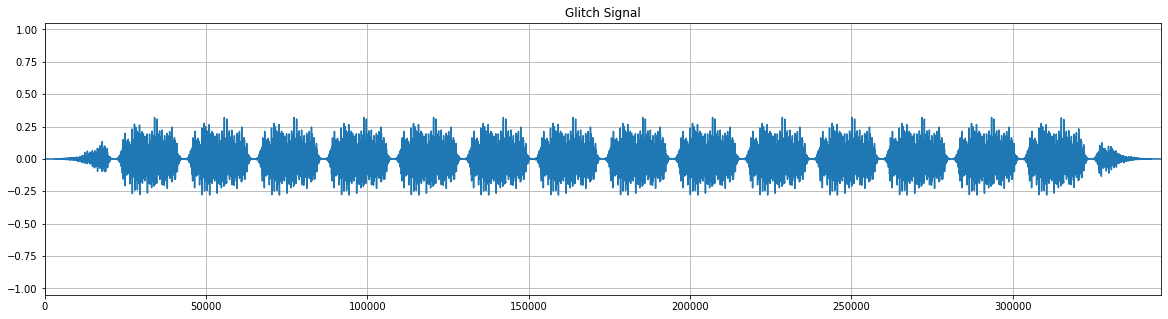

   Index 5 (486286)


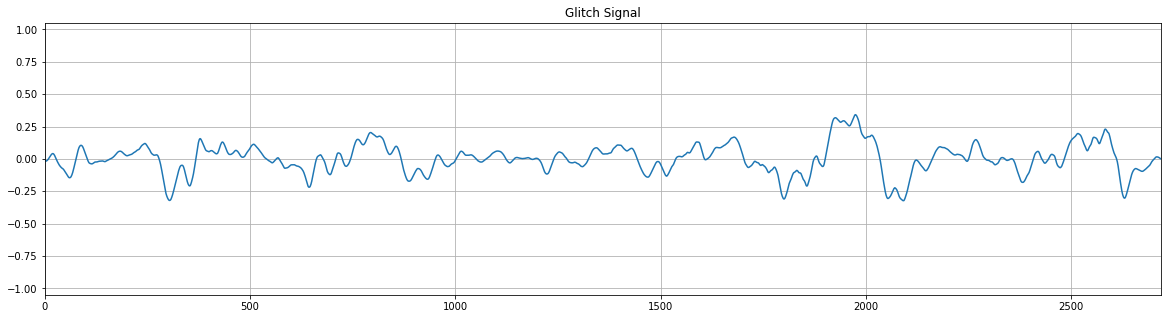

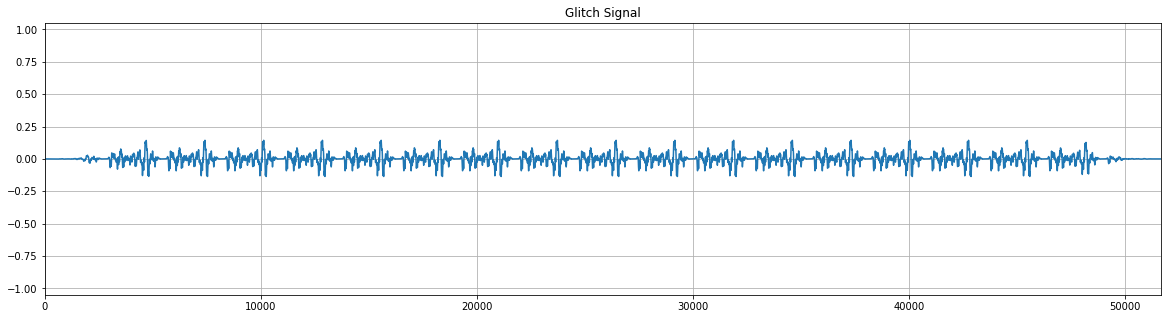

   Index 6 (214732)


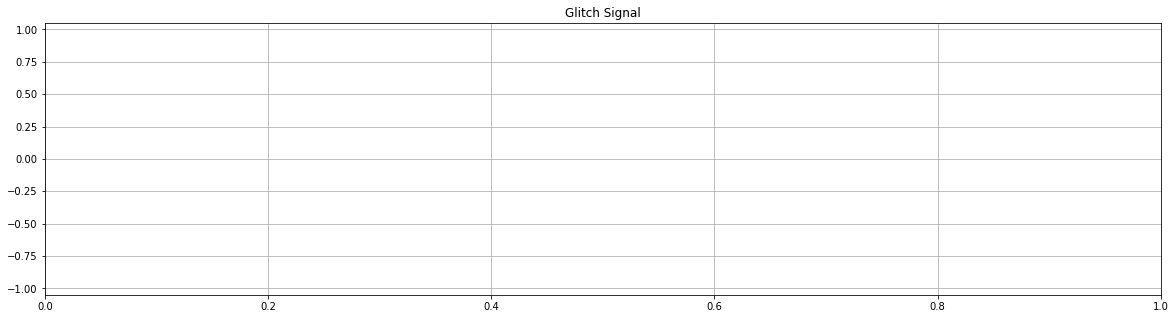

[glitch()] Corrupted glitch signal! Returning unprocessed signal ...
   Index 1 (31581)
   Index 2 (213150)


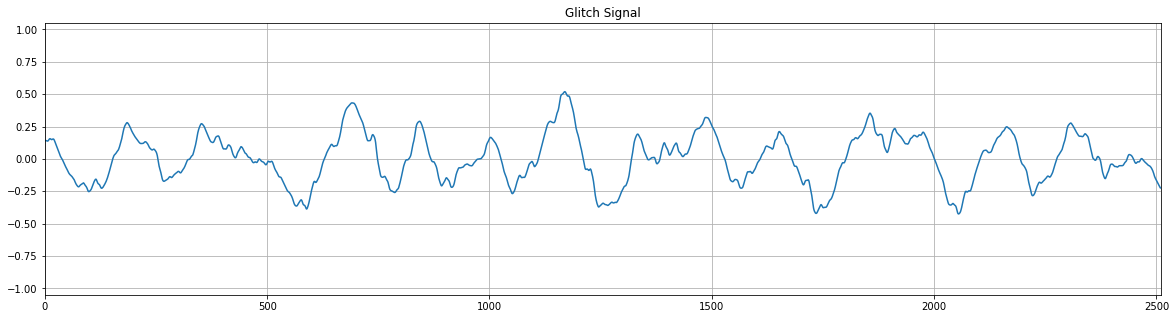

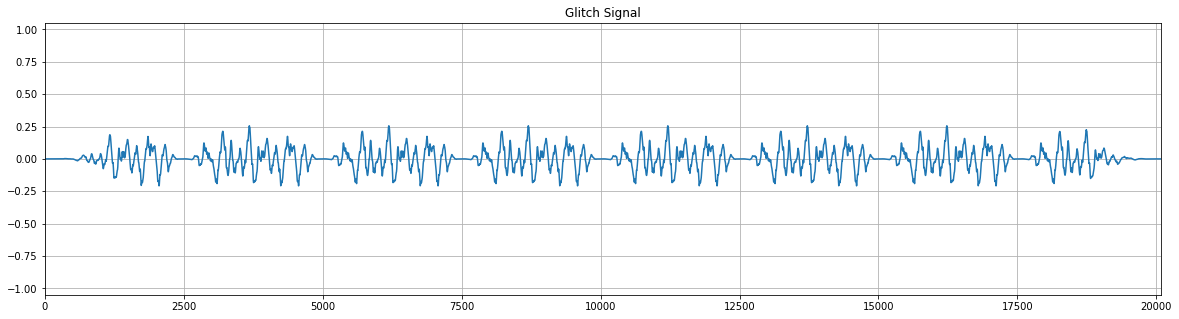

   Index 3 (233399)
   Index 4 (78221)
   Index 5 (100931)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 6 (306716)
   Save audio . . .
Epoch 3
   Index 1 (397870)
   Index 2 (403804)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 3 (339034)
   Index 4 (514780)
   Index 5 (307635)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 6 (79325)


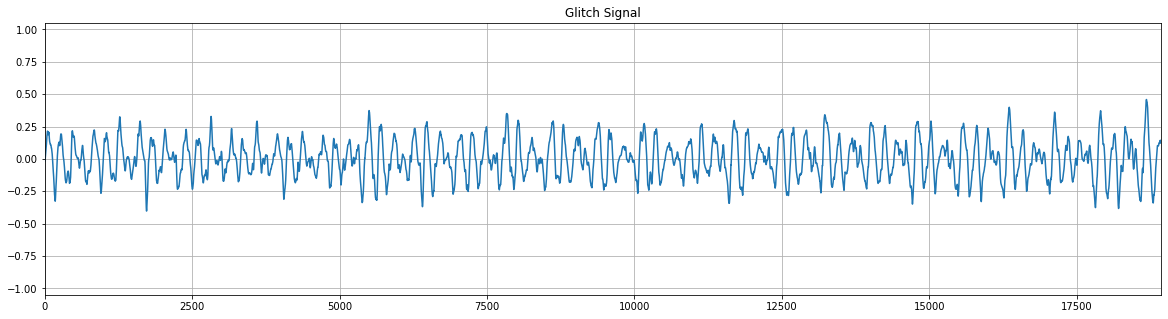

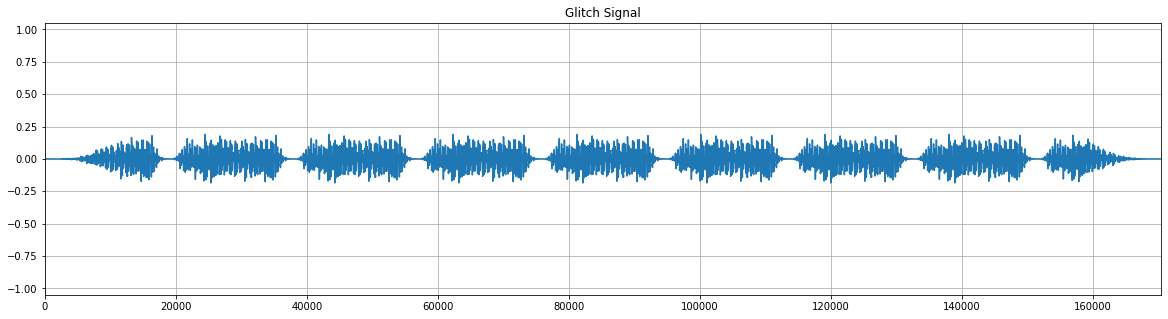

   Index 1 (510304)
   Index 2 (116089)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 3 (623666)
   Index 4 (563002)
   Index 5 (168471)
   Index 6 (11392)
   Save audio . . .
Epoch 4
   Index 1 (778416)


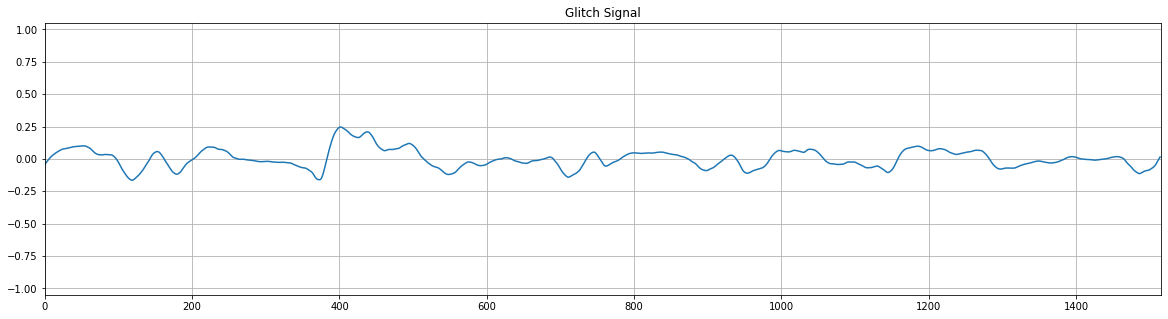

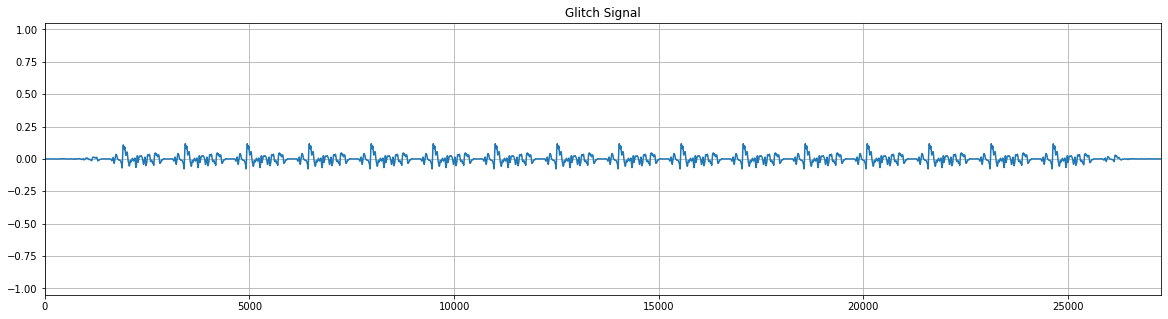

   Index 2 (424771)


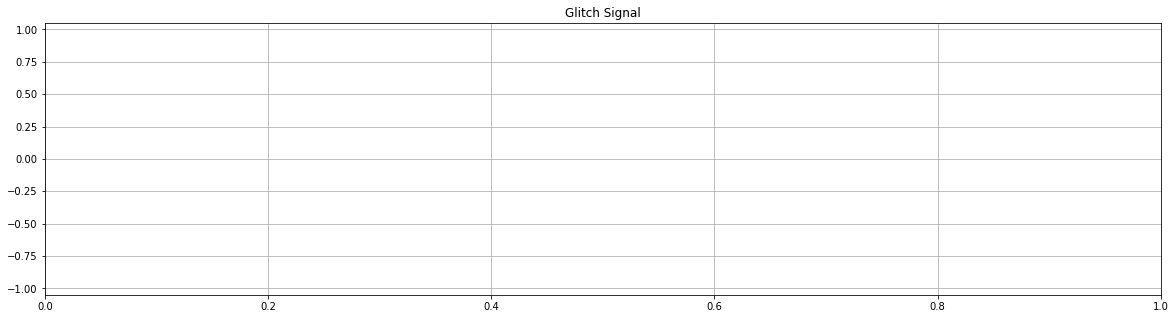

[glitch()] Corrupted glitch signal! Returning unprocessed signal ...
   Index 3 (754880)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 4 (515899)
   Index 5 (282422)
   Index 6 (458816)


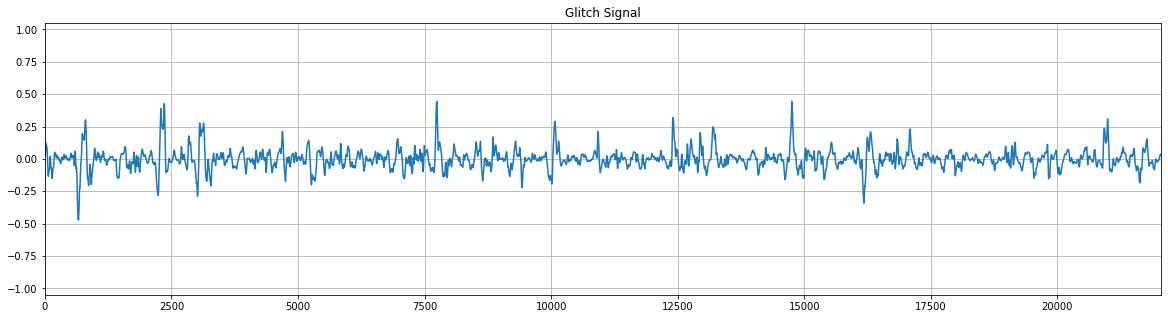

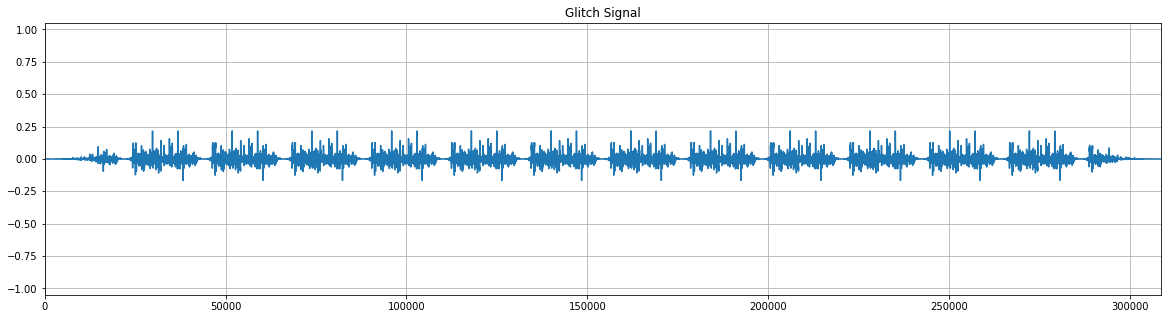

   Index 1 (571237)
   Index 2 (9358)
   Index 3 (653636)
   Index 4 (539696)
   Index 5 (438324)
[decay_mod_signal()] Width must be lower than signal length! Returning unprocessed signal ...
   Index 6 (378871)
   Save audio . . .
Epoch 5
   Index 1 (782185)
   Index 2 (754098)


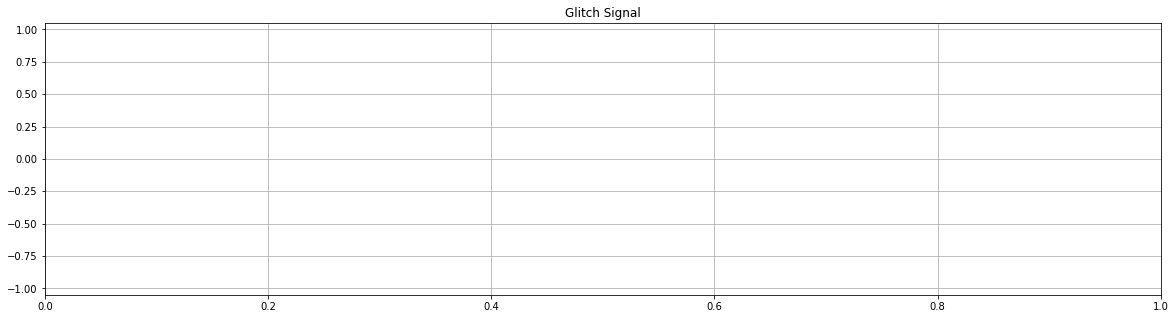

[glitch()] Corrupted glitch signal! Returning unprocessed signal ...
   Index 3 (551573)


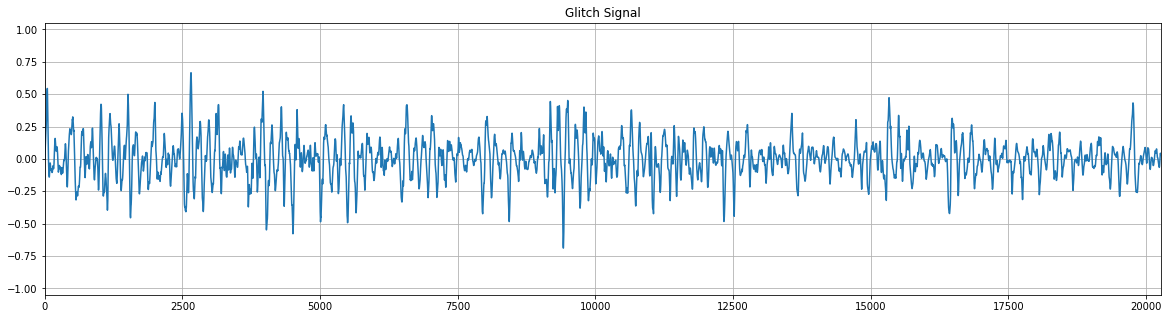

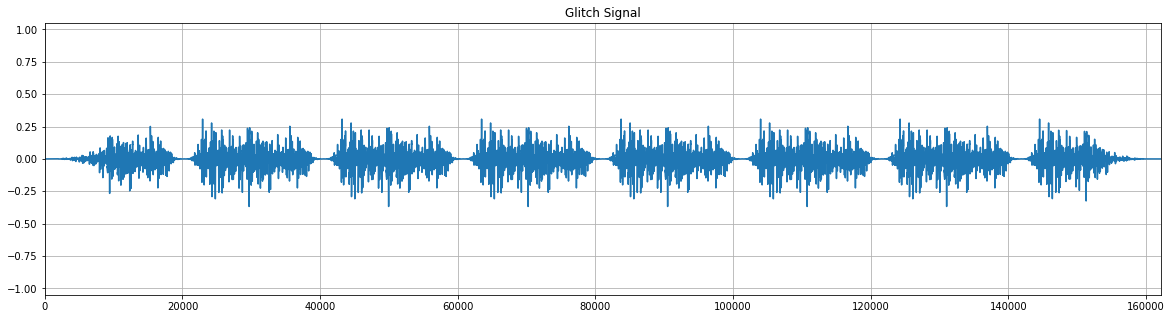

   Index 4 (243556)


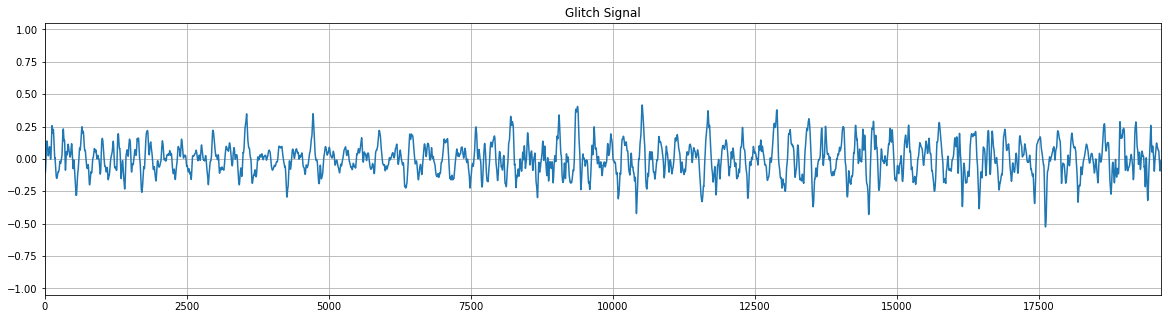

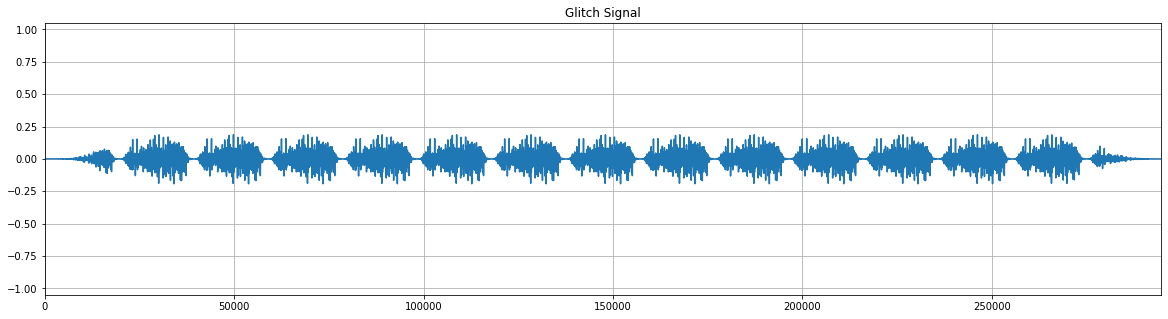

   Index 5 (394157)


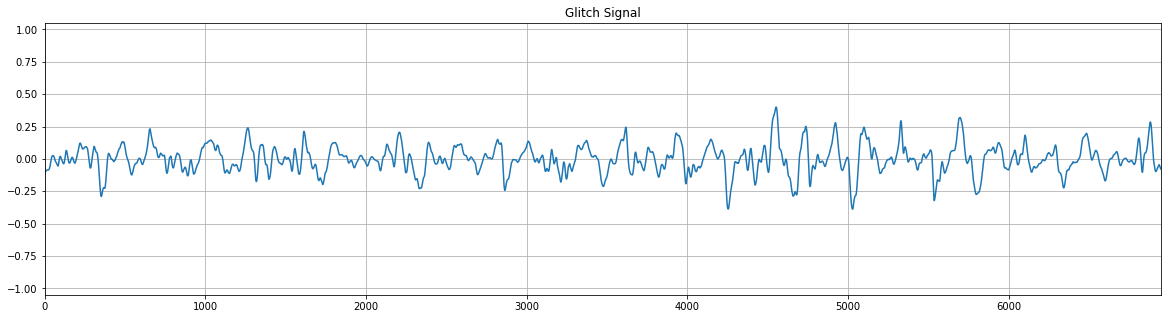

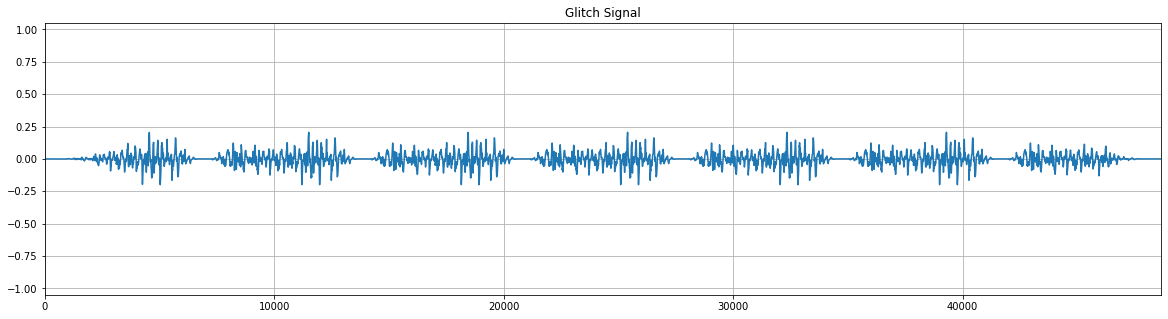

   Index 6 (283150)
   Index 1 (552353)


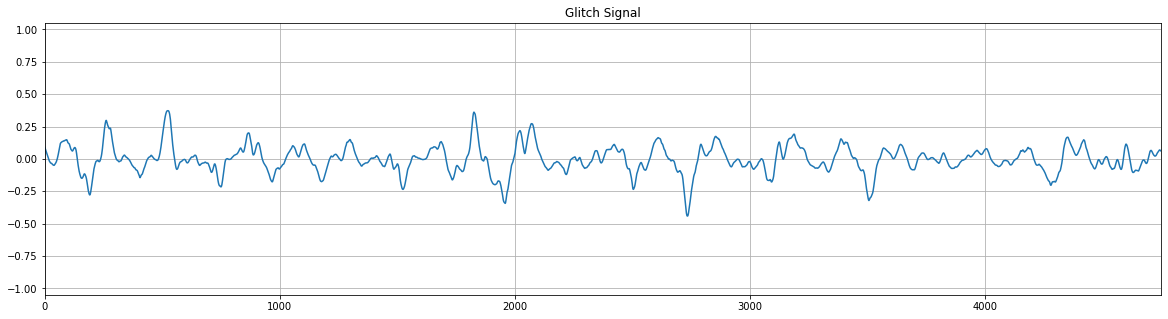

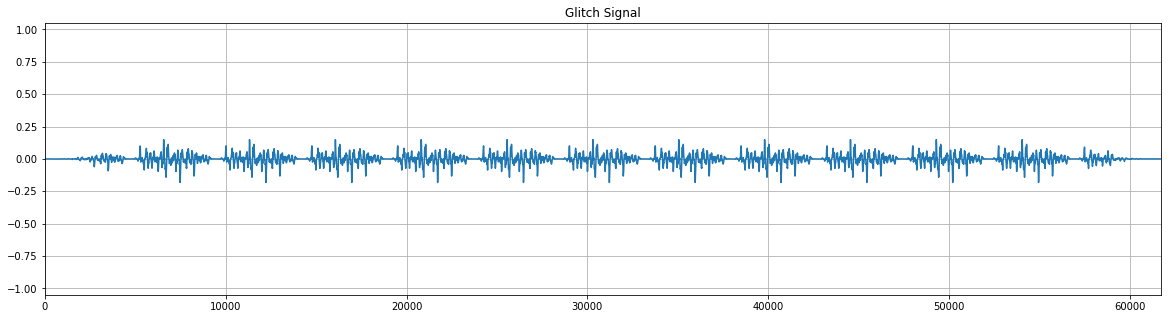

   Index 2 (342994)
   Index 3 (29714)


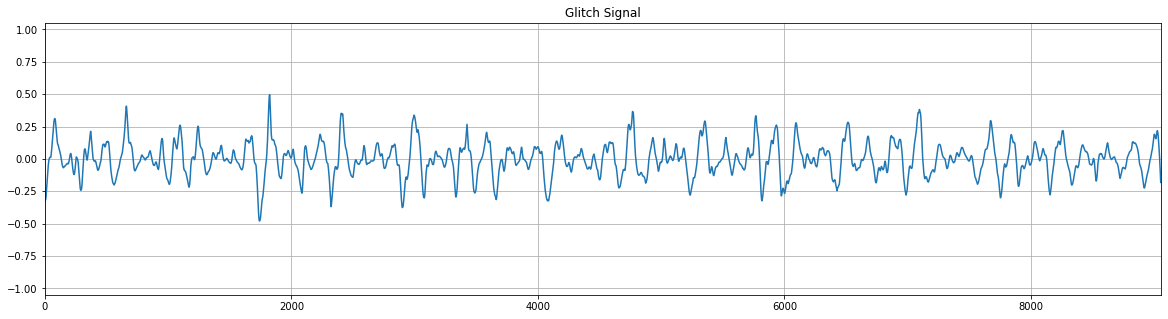

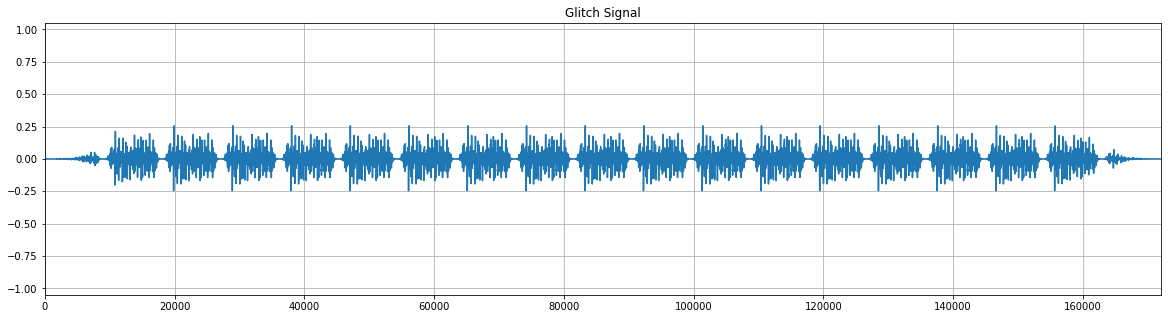

   Index 4 (254738)
   Index 5 (234627)
   Index 6 (192370)
   Save audio . . .
Epoch 6
   Index 1 (587813)
   Index 2 (734843)


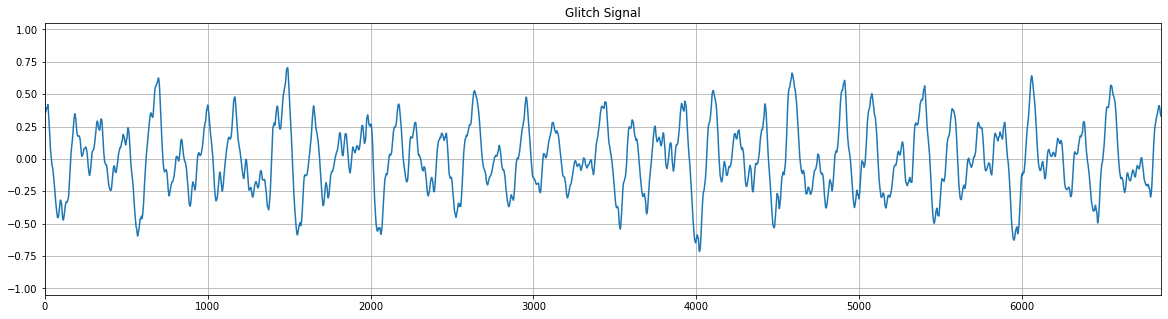

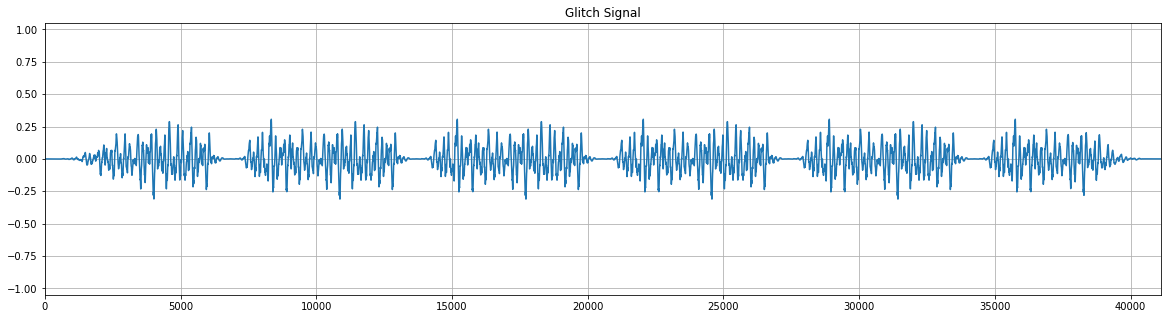

   Index 3 (451868)


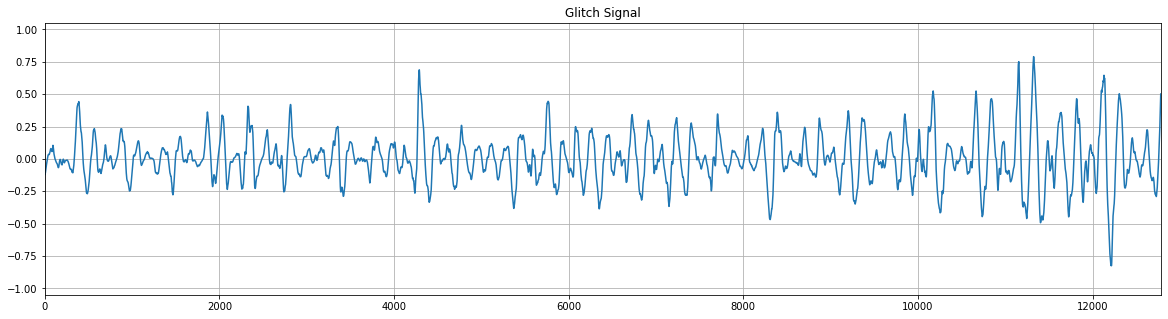

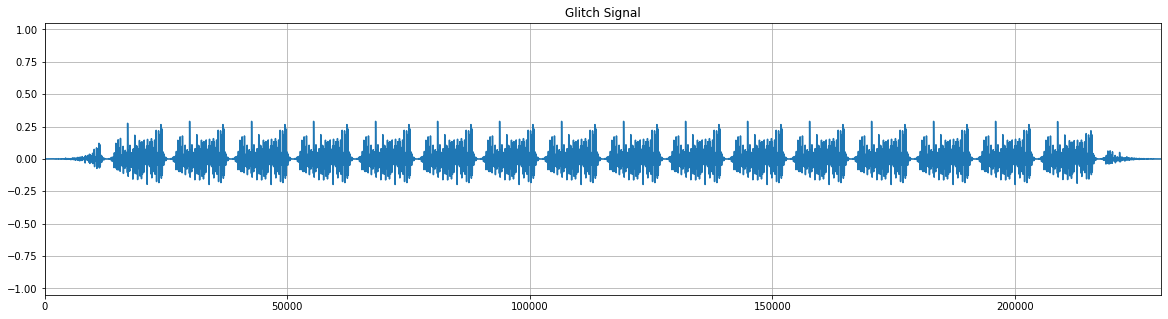

   Index 4 (94453)


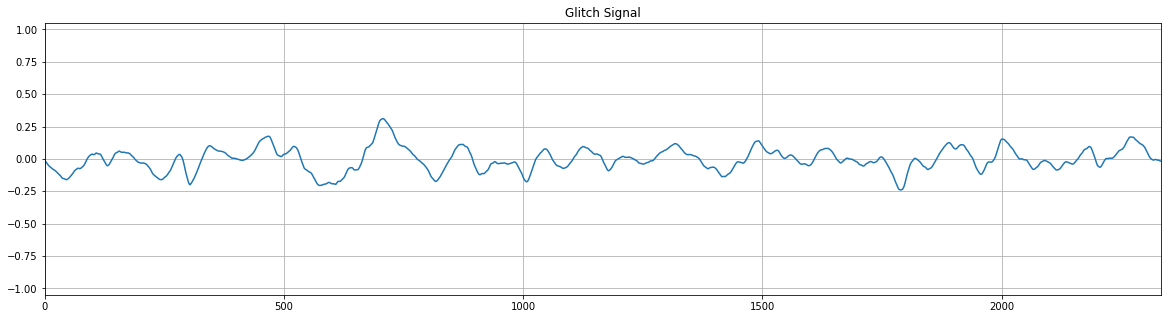

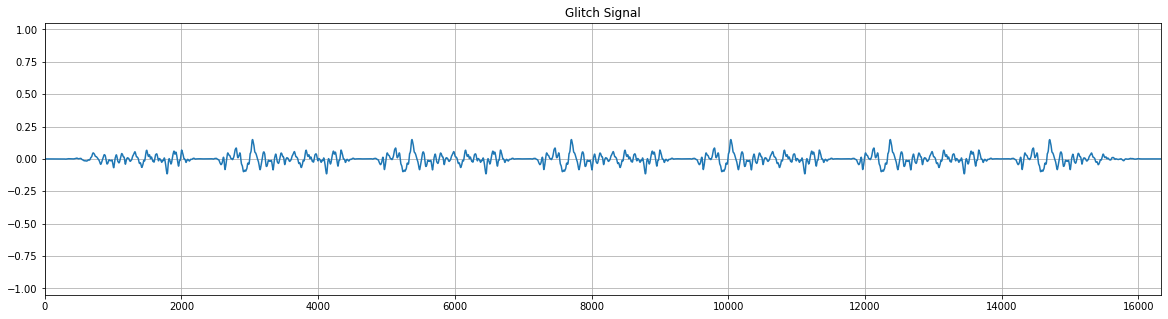

KeyboardInterrupt: 

In [51]:
# main

'''main loop for processing signal. i tried to make useful comments for all variables you can play with.
   if you get index errors, you probably chose unfittig variable values. sometimes the functions return
   error messages, but the unprocessed signal gets returned so that the processing can continue. i chose
   weird formulas for some variables just to make sure they are fitting well, but you can as well choose
   simple numbers.'''

write_audio = True # if true, every epoch an audio file gets written (you can change directory and filname at the end of the main loop below)
audio_normalization = True # if true, audio gets normalized at end of each epoch. otherwise it gets quiter with each epoch

decayed_signal = np.copy(signal) # copy signal for processing

n_decay_indices = 6 # number of indices at which decay occurs (per epoch per channel)
n_epochs = 50 # number of epochs (processing iterations)

for i in range(n_epochs):
    
    print('Epoch ' + str(i + 1))
    
    for j in range(len(decayed_signal)):
    
        for k in range(n_decay_indices):
            
            # glitch algorithm
            
            glitch_probability = random.uniform(0, 1) # probability with which glitch will occur
            
            if (glitch_probability > 0.6): # probability with which glitch will occur
            
                glitch_index = np.random.randint(0, len(decayed_signal[0])) # index at which glitch will occur
                
                glitch_width = np.random.randint(int(fs * 0.01), int(fs * 0.5)) # width of glitch signal which gets repeated n_glitches times
                glitch_weight = random.uniform(0.4, 0.6) # weight of glitch signal (volume compared to source signal)
                n_glitches = np.random.randint(6, 20) # number of glitch repetitions
                
                decayed_signal[j] = glitch(decayed_signal[j], glitch_index, glitch_width, glitch_weight, n_glitches) # calculate glitched signal
            
            
            # decay algorithm
            
            coinflip = random.choice(['head', 'tail'])
            
            decay_index = np.random.randint(0, len(decayed_signal[0])) # index at which decay will occur
            
            if (coinflip == 'head'): # coinflip chooses decay_perlin algorithm
            
                decay_width = int(log_scaling(random.uniform(0, 1)) * len(decayed_signal[0]) / 2) # width of decay signal, centered around decay_index
                decay_weight = 1 - (decay_width / len(decayed_signal[0])) # weight of decay signal (volume reduction factor)
                pn_frequency = 3 # frequency of perlin noise (unfortunately random int values dont work here and i dont know why ...)
                pn_type = random.choice(['smooth', 'smooth', 'sharp']) # choose random algorithm style
                fade_l = decay_width - np.random.randint(0, decay_width) # length of left fade
                fade_r = decay_width - fade_l # length of right fade

                decayed_signal[j] = decay_perlin(decayed_signal[j], decay_index, decay_width, decay_weight, pn_frequency, pn_type, fade_l, fade_r) # calculate decayed signal
            
            elif (coinflip == 'tail'): # coinflip chooses decay_mod_signal algorithm
            
                mod_signal = random.choice(mod_signals) # choose random modulation signal of mod_signals array
                
                if (len(mod_signal) > len(decayed_signal[j])): # makes sure that decay_width doesnt get an index error
                    decay_width_border = len(mod_signal)
                else:
                    decay_width_border = len(decayed_signal[j])
                
                decay_width = int(log_scaling(random.uniform(0, 1)) * len(mod_signal) / 2) # width of decay signal, centered around decay_index
                decay_weight = 1 - (decay_width / len(mod_signal)) # weight of decay signal (volume reduction factor)
                fade_l = decay_width - np.random.randint(0, decay_width) # length of left fade
                fade_r = decay_width - fade_l # length of right fade

                decayed_signal[j] = decay_mod_signal(decayed_signal[j], decay_index, decay_width, decay_weight, mod_signal, fade_l, fade_r) # calculate decayed signal
                
            print('   Index ' + str(k + 1) + ' (' + str(decay_index) + ')')
            
    if (write_audio):
        
        print('   Save audio . . .')
        
        filename = 'generated_audio/decayed_signal_epoch_' + str(i + 1) + '.wav'
        data = np.transpose(decayed_signal)
        
        if (audio_normalization):
            data /= np.amax(np.abs(data))
            
        wavfile.write(filename, fs, data)
            
# plotting

plt.figure(figsize=(fig_width, fig_height))
plt.title('Left Channel (Decayed)')
plt.plot(decayed_signal[0])
plt.grid('both')
plt.xlim([0, len(decayed_signal[0])])
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.title('Right Channel (Decayed)')
plt.plot(decayed_signal[1])
plt.grid('both')
plt.xlim([0, len(decayed_signal[1])])
plt.show()

ipd.Audio(decayed_signal[0], rate=fs)